# What makes a Kickstarter campaign successful?

## Project Overview

The main purpose of our research project is to predict what makes a successful Kickstarter campaign. We will evaluate what kind of campaign people donate the most (e.g. board games, movies, apps, etc). In addition, we have built a model for predicting the success rate of campaigns based on different features of the campaign. 

This is important as it helps people who potentially want to do a Kickstarter know the most effective ways for achieving success. Sites such as Kickstarter and Indiegogo have become immensely popular, but not every campaign is successful. Being able to predict which projects are likely to succeed or fail can stop customers from spending their money on a risky project. Since 2012, Kickstarter had over 400,000 campaigns and there have been more 3.9 billion dollars pledged to campaigns. Of that 3.9 billion dollars, 408 million dollars have been spent on unsuccessful campaigns Kickstarter Statistics 2012-2018. Thus, from our data, inventors and investors alike can benefit the most from Kickstarter. 

Over 300,000 Kickstarter projects have been web-scraped from the Kickstarter platform and combined into one Kaggle dataset  containing information on many aspects of each campaign. Each campaign happened in the time frame of 2011 to 2015 and was deemed successful or unsuccessful (whether the campaign reached its original goal). Some of the features captured in each campaign are: 

- Name: name of project 
- Main Category: category of campaign
- Currency: currency used to support
- Deadline: date end for crowdfunding
- Goal: fundraising goal (the amount of money that a creator needs to complete their project)
- Launched: date the campaign was launched
- Pledged: amount pledged by "crowd"
- State: condition the project finished in (failed, successful, canceled)
- Backers: number of backers (count of investors)

Out of this data, we can explore many relationships between the State (whether it was successful or not) and other features. In other words, do these features have a relationship with the outcome/state? These data points can be further divided into features that predict the outcome of the campaign (whether its successful or not) and those that are found after a campaign ends (the amount of success, money, etc.). The after data can be used in training and testing a machine learning algorithm. 


## Data Cleaning & Feature Engineering

To address null values or messy data found in the dataset, we implemented proper data cleaning techniques. For any null values, the value was filled with the average of the column/feature. Categorical data was converted into numerical values with a Label Encoder, which gave all unique categories a number. In addition, the dataset included campaigns that were still running. Because the data was scraped at a certain time, we removed all of these campaigns as their state variables would not be correct as compared to the rest of the data (the campaigns were still ongoing and could be a false negative). 

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.pipeline import make_pipeline,make_union
from sklearn.preprocessing import MinMaxScaler, Imputer,PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
import warnings
from sklearn.feature_selection import SelectKBest, VarianceThreshold
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

In [36]:
#Load the data
origin_data = pd.read_csv('./Data/ks-projects-201801.csv',index_col=[0])

data = origin_data.copy()
#In this project, we ignore the title's factor to the successful rate. 
#data.drop("name",inplace=True, axis=1)

#We only consider the projects are completed. 
data = data[data.state != "live"]

#There are many other states like failed, suspended, we consider them as failed.
data.state = data.state == "successful"

In [37]:
#Convert the data to datetime
data.deadline = pd.to_datetime(data.deadline)
data.launched = pd.to_datetime(data.launched)

In [38]:
# Remove data points that say date launched is in 1970
low = min(data.launched)
data = data[data.launched != low]

### Check for Null data and use bfill to fill the data


In [39]:
pd.isna(data).any()
data.fillna(method="bfill",inplace=True)

In [40]:
data.category = "sub_"+ data.category
rawdata = data.copy()
le = LabelEncoder()
total =[]
for col in data.columns:
        if col != "name":
            if data.dtypes[col] == "object":
                total +=  list(data[col].astype(str))
le.fit(total)
for col in data.columns:
        if col != "name":
            if data.dtypes[col] == "object":
                data[col] = le.transform(data[col].astype(str))

In [41]:
num_cam = data['launched'].groupby([data['launched'].dt.year.rename('year'), data['launched'].dt.month.rename('month')]).agg({'count'})


In [42]:
data["month"] = data["launched"].dt.month
data["month_deadline"] = data["deadline"].dt.month
data["launch_day_of_week"] = data["launched"].dt.dayofweek
data["duration"] = ((data["deadline"]  - data['launched'])/ np.timedelta64(1, 'D')).astype(int)
data["year"] = data["launched"].dt.year

In [43]:
data = pd.merge(data, num_cam, on=["month","year"])

In [44]:
data.head(2)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,month,month_deadline,launch_day_of_week,duration,year,count
0,The Songs of Adelaide & Abullah,160,43,23,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,22,0.0,0.0,1533.95,8,10,1,58,2015,5723
1,Legacy of Svarog | a Unique 3D Action RPG and ...,200,24,51,2015-10-30,50000.0,2015-08-31 06:33:31,1410.0,False,38,50,1410.0,1410.0,50000.00,8,10,0,59,2015,5723


In [45]:
%store data
%store le
%store rawdata

Stored 'data' (DataFrame)
Stored 'le' (LabelEncoder)
Stored 'rawdata' (DataFrame)


### Convert Catagorial Data to Numerical

### Feature Engineering

There were a couple new features engineered in our data exploration. First, a duration variable was created that found the number of days between the date started and the date ended. Kickstarter states, “We recommend setting your campaign at 30 days or less.,” (Kickstarter Help Website). Therefore, while Kickstarter allows users to set their duration up to 60 days, duration of the campaign affects the overall success. 


Another feature was the Day of Week that the campaign was launched. We wanted to explore whether the state had a relationship with this variable. Do people generally donate more or are exposed to more campaigns on certain days of the week? This variable was found by a simple algorithm that found the day of the week from the exact date given. 


Next, we further separated the state variable into a more in-depth range of data. Essentially, the State feature was separated into the range of: ‘Extreme Failure’, ‘Failed’, ‘Successful’, ‘Very Successful’ which divided the state into more categories by the differences in goal and the amount failed/succeeded. 


Finally, we wanted to assess how many projects were created in the month that a project was released. This may affect the success of a project. For example, if many other projects were launched around the same time, one campaign may be hidden/overshadowed by the many other campaigns. Therefore, a column was created that counted the number of campaigns launched in that month. 


## Exploratory Data Analysis

Data exploration was first done to understand the distribution of data and the relationships between different features. The first four visualizations explain the distributions of campaigns by categories and sub-categories. In addition, the rate of success for all campaigns in the dataset is shown in a detailed summary below. Finally, we have explored the correlations between features with a heat map. The lighter the square, the more correlated the two features are to each other. Using this visualization, we can explore models and machine learning algorithms with the most correlated features. 


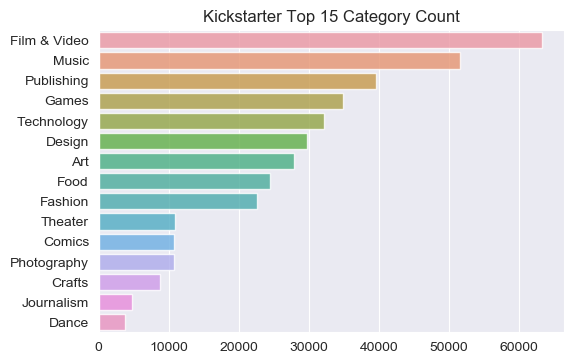

In [12]:
sns.set_style('darkgrid')
mains =rawdata.main_category.value_counts().head(15)

x = mains.values
y = mains.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', alpha=0.8)

plt.title('Kickstarter Top 15 Category Count')
plt.show()

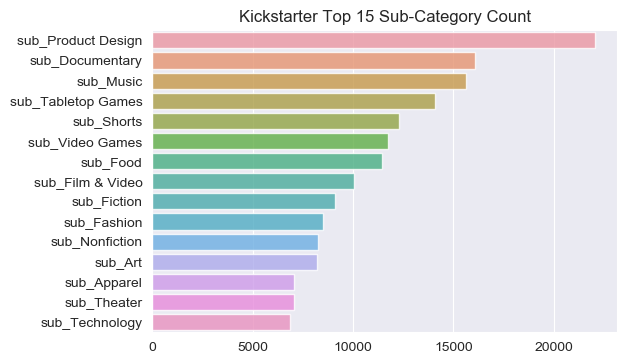

In [13]:
cats = rawdata.category.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', alpha=0.8)

plt.title('Kickstarter Top 15 Sub-Category Count')
plt.show()

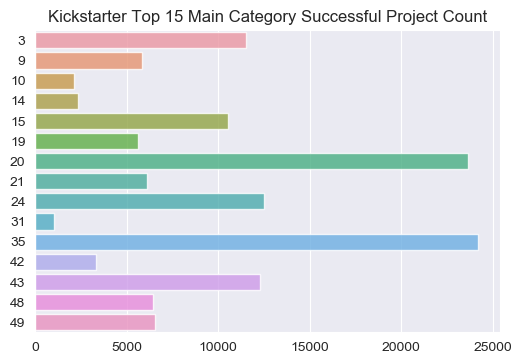

In [14]:
successful_data = data[data.state == 1]
suc_cats = successful_data.main_category.value_counts().head(15)

x = suc_cats.values
y = suc_cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h',  alpha=0.8)

plt.title('Kickstarter Top 15 Main Category Successful Project Count')
plt.show()

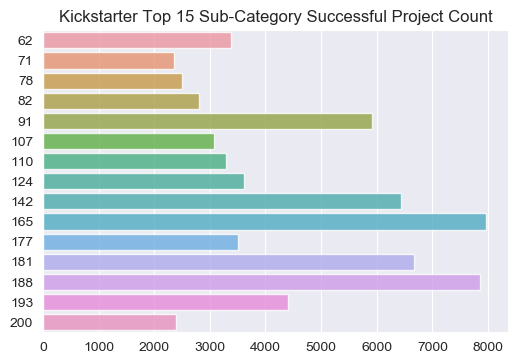

In [15]:
successful_data = data[data.state == 1]
suc_cats = successful_data.category.value_counts().head(15)

x = suc_cats.values
y = suc_cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', alpha=0.8)

plt.title('Kickstarter Top 15 Sub-Category Successful Project Count')
plt.show()

In [16]:
print("Total Number of Completed Projects:", len(data),"\n"
      "Total Number of Successful Projects:", len(data[data.state == 1]),"\n"
      "Successful Rate Among All projects:",str(round(len(data[data.state == 1])/len(data)* 100,2)) + "%\n"
      "Number of Catagories: Main catagories num -", len(set(data["main_category"])), "Sub catagories num -", len(set(data["category"])),"\n"
     )

Total Number of Completed Projects: 375855 
Total Number of Successful Projects: 133956 
Successful Rate Among All projects: 35.64%
Number of Catagories: Main catagories num - 15 Sub catagories num - 159 



In [17]:
data.describe(percentiles=[0.3,0.7])

,category,main_category,currency,goal,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,month,month_deadline,launch_day_of_week,duration,year,count
count,375855.000000,375855.000000,375855.000000,3.758550e+05,3.758550e+05,375855.000000,375855.000000,3.758550e+05,3.758550e+05,3.758550e+05,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000,375855.000000
mean,132.781833,26.595474,43.721326,4.887546e+04,9.687611e+03,105.898839,42.864804,7.072522e+03,9.082847e+03,4.532795e+04,6.425505,6.761929,2.421998,33.161703,2014.227838,4835.965085
std,45.088332,13.459365,14.543028,1.176606e+06,9.588738e+04,909.960752,14.309311,7.861419e+04,9.127160e+04,1.145876e+06,3.310168,3.320284,1.764473,12.781795,1.915768,1902.250758
min,52.000000,3.000000,2.000000,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,1.000000,1.000000,0.000000,0.000000,2009.000000,2.000000
30%,104.000000,20.000000,51.000000,2.500000e+03,7.000000e+01,3.000000,50.000000,4.000000e+01,7.000000e+01,2.500000e+03,4.000000,5.000000,1.000000,29.000000,2013.000000,3962.000000
50%,139.000000,21.000000,51.000000,5.100000e+03,6.250000e+02,12.000000,50.000000,4.000000e+02,6.276000e+02,5.480040e+03,6.000000,7.000000,2.000000,29.000000,2014.000000,4463.000000
70%,165.000000,35.000000,51.000000,1.250000e+04,2.942000e+03,42.000000,50.000000,2.108000e+03,2.929000e+03,1.239111e+04,9.000000,9.000000,3.000000,32.000000,2015.000000,5659.000000
max,210.000000,49.000000,51.000000,1.000000e+08,2.033899e+07,219382.000000,50.000000,2.033899e+07,2.033899e+07,1.663614e+08,12.000000,12.000000,6.000000,91.000000,2018.000000,10775.000000


In [18]:
data.corr()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,month,month_deadline,launch_day_of_week,duration,year,count
category,1.000000,0.157745,-0.012241,0.003316,0.028928,0.022525,0.041134,-0.012489,0.025946,0.029428,0.002602,-0.001640,-0.005785,-0.004688,-0.002725,-0.039151,-0.041853
main_category,0.157745,1.000000,-0.016446,0.003344,0.002720,-0.033624,-0.005700,-0.016746,0.003370,0.003672,0.001594,0.000854,-0.005377,0.001444,0.036912,-0.009984,0.004988
currency,-0.012241,-0.016446,1.000000,-0.005467,0.005864,0.067147,0.012154,0.979930,0.014107,0.010847,-0.003873,-0.028363,-0.022718,0.004535,0.026527,-0.275799,-0.158487
goal,0.003316,0.003344,-0.005467,1.000000,0.007339,-0.024484,0.004076,-0.004920,0.005596,0.005172,0.941677,0.000953,0.000298,-0.002276,0.023182,0.015802,0.012781
pledged,0.028928,0.002720,0.005864,0.007339,1.000000,0.111849,0.717427,0.005672,0.856305,0.953369,0.005099,0.002461,0.005791,-0.025551,0.006499,0.029876,0.002260
state,0.022525,-0.033624,0.067147,-0.024484,0.111849,1.000000,0.129229,0.066113,0.097319,0.110785,-0.023246,-0.011573,-0.002458,-0.018806,-0.116745,-0.085862,-0.130738
backers,0.041134,-0.005700,0.012154,0.004076,0.717427,0.129229,1.000000,0.012082,0.697003,0.752489,0.004584,-0.002282,0.003404,-0.028077,-0.001488,0.016966,-0.002120
country,-0.012489,-0.016746,0.979930,-0.004920,0.005672,0.066113,0.012082,1.000000,0.013859,0.010902,-0.003072,-0.026803,-0.021430,0.003597,0.028515,-0.273136,-0.158088
usd pledged,0.025946,0.003370,0.014107,0.005596,0.856305,0.097319,0.697003,0.013859,1.000000,0.905955,0.006240,-0.005888,-0.003462,-0.020130,0.006212,-0.006257,0.008754
usd_pledged_real,0.029428,0.003672,0.010847,0.005172,0.953369,0.110785,0.752489,0.010902,0.905955,1.000000,0.005669,0.000119,0.004185,-0.025894,0.007061,0.022517,0.002870


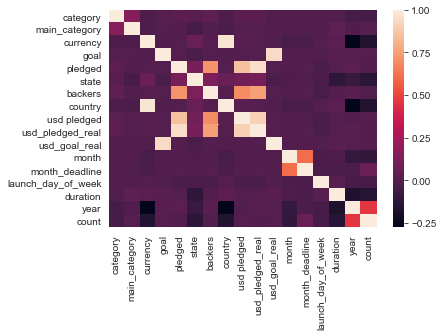

In [19]:
sns.heatmap(data.corr(), 
        xticklabels=data.corr().columns,
        yticklabels=data.corr().columns)

Next, we explored the distribution of campaigns by their goal amount. The most successful project to ever be created on Kickstarter was the Pebble watch. This successful product hit its goal within the first 17 minutes of being launched. The campaign still continued to grow in the amount of money, even though it had hit its goal. Therefore, we explored the relationship between having a small goal and the success of a campaign. These two visualizations below breakdown the success number and failed number at each goal amount. Note that because of the large distribution of goals, the graph was separated into the first section of goals from 0 to 100,000 and a second section of 100,000 to 1,000,000. 

In [20]:
# Separate data into two different sets based on whether or not the campaign was successful
success = data.loc[data['state'] == True]
fail = data.loc[data['state'] == False]

Text(0.5,1,'Normalized Distribution of Goal Amounts for Successful and Failed Projects (0-100000 dollars)')

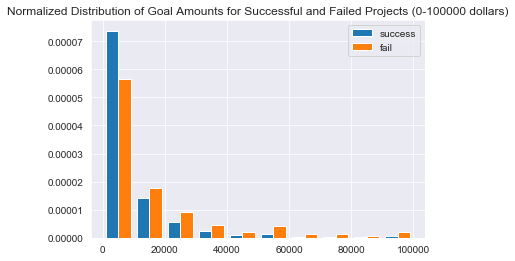

In [21]:
plt.hist([success.goal, fail.goal], range=[0, 100000], label=['success', 'fail'], density=True)
plt.legend()
plt.title('Normalized Distribution of Goal Amounts for Successful and Failed Projects (0-100000 dollars)')

Text(0.5,1,'Normalized Distribution of Goal Amounts for Successful and Failed Projects (100000-1000000 dollars)')

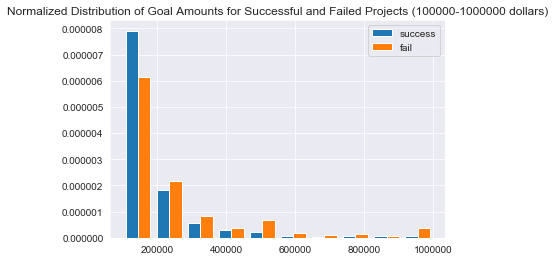

In [22]:
plt.hist([success.goal, fail.goal], range=[100000, 1000000], label=['success', 'fail'], density=True)
plt.legend()
plt.title('Normalized Distribution of Goal Amounts for Successful and Failed Projects (100000-1000000 dollars)')

Text(0.5,1,'Normalized Distribution of Campaign Length for Successful and Failed Projects')

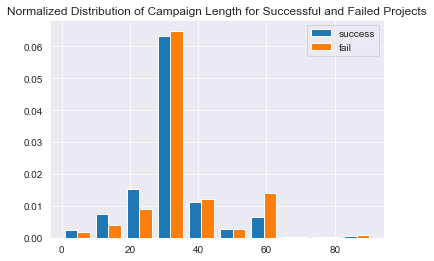

In [23]:
plt.hist([success.duration, fail.duration], label=['success', 'fail'], density=True)
plt.legend()
plt.title('Normalized Distribution of Campaign Length for Successful and Failed Projects')

The time at which the campaign was released was also explored. First, the month at which the project was launched was compared with the number of campaigns that were successful and those that were not successful in the end of their campaign. When a campaign is first launched, it generally makes a lot of money in the beginning and when it is about to close. Therefore, the launch month was compared with these success and fail project counts. In addition, the day of the week that a project was launched and the success or failure state was compared. The scale for the day of the week corresponds to 0 = Monday and so on. 

Text(0.5,1,'Normalized Distribution of the Month the Campaign was launched for Successful and Failed Projects')

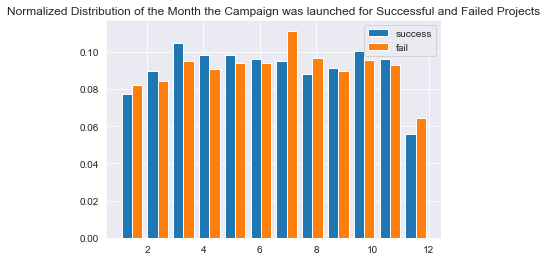

In [24]:
plt.hist([success.month, fail.month], bins=12, density=True, label=['success', 'fail'])
plt.legend()
plt.title('Normalized Distribution of the Month the Campaign was launched for Successful and Failed Projects')

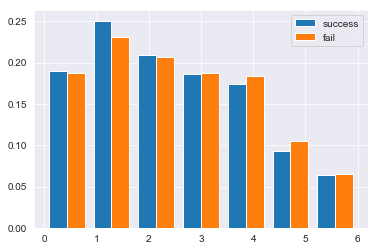

In [25]:
plt.hist([success.launch_day_of_week, fail.launch_day_of_week], bins=7, density=True, label=['success', 'fail'])
plt.legend()

## Statistical Modeling

In [26]:
# Statistical Modeling code here: 
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

In [27]:
%store -r data
%store -r le
data.state = data.state.astype(int)


### Multiple Regression

In [28]:
# Creates Model
full_model = smf.ols(formula='state ~ goal + pledged + category + main_category + backers + country', data=data).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  state   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1529.
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        18:47:19   Log-Likelihood:            -2.5208e+05
No. Observations:              375855   AIC:                         5.042e+05
Df Residuals:                  375848   BIC:                         5.043e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2575      0.004     72.185      0.000       0.250       0.264
goal          -1.011e-08   6.56e-10    -15.404      0.000   -1.14e-08   -8.82e-09
pledged        2.027e-07   1.16e-08     17.542      0.000     1.8e-07    2.25e-07
category          0.0003   1.74e-05     14.592      0.000       0.000       0.000
main_category    -0.0013   5.81e-05    -21.915      0.000      -0.001      -0.001
backers        5.171e-05   1.22e-06     42.444      0.000    4.93e-05    5.41e-05
country           0.0022    5.4e-05     39.870      0.000       0.002       0.002
==============================================================================
Omnibus:                    15870.774   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19191.574
Skew:                           0.474   Prob(JB):                         0.00
Kurtosis:                       3.573   Cond. No.                     5.44e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# Make predictions
data['mult_predictions'] = full_model.predict()
data.loc[data["mult_predictions"] >= 0.5,"mult_predictions"] = 1
data.loc[data["mult_predictions"] < 0.5,"mult_predictions"] = 0

<function matplotlib.pyplot.show(*args, **kw)>

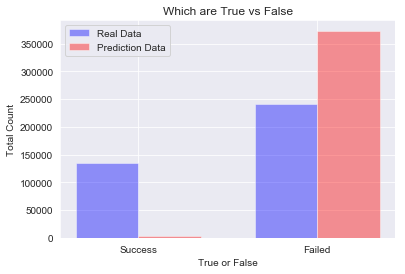

In [30]:
# Visualize results
real_success = len(data[data['state'] == 1])
fake_success = len(data[data['mult_predictions'] == 1])
real_failed = len(data[data['state'] == 0])
fake_failed = len(data[data['mult_predictions'] == 0])

x = ['Pass', 'Fail']
real = [real_success, real_failed]
fake = [fake_success, fake_failed]

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.4
N = 2
ind = np.arange(N)

rects1 = ax.bar(ind, real, bar_width, alpha=opacity, color='b', label='Real Data')
rects2 = ax.bar(ind + bar_width, fake, bar_width, alpha=opacity, color='r', label='Prediction Data')
ax.set_xlabel('True or False')
ax.set_ylabel('Total Count')
ax.set_title('Which are True vs False')
ax.set_xticks(ind + bar_width / 2)
ax.set_xticklabels(('Success', 'Failed'))
ax.legend()

plt.show

In [31]:
# Percent of correct predictions
len(data[data["mult_predictions"]== data["state"]]) / len(data["state"])

0.650418379428237

## Machine Learning

Before we can do any actual machine learning, we have to first split our data into a test set, and a training set. Since our data set is particularly large, I chose to make the training set a little bit bigger because that will allow the model to have a better fit without worrying about possibility of over fitting. There's still a lot of data in the test set to validate.

In [46]:
feature = data[['category', 'main_category', 'currency', 'goal','duration', 'country', 'month', 'month_deadline', 'launch_day_of_week', 'count']]
outcome = data[['state']]
feature_name = data[["name"]]

We can this pretty easily by first selecting all the relevant features and put those into a data frame. Next, we can put the outcome of the data into it's own data frame as well. We can then split the data into a training set and a test set using the function below.

In [47]:
train_features_small, test_features, train_outcome_small, test_outcome = train_test_split(
    feature,
    outcome,
    test_size = 0.3
)

### Random Forest

We tried many different *many* different machine learning algorithms over the course of this study but none performed as well as Random Forest. Random Forest is fairly similar to a Decision Tree algorithm but *differs* in that a Random Forest builds *multiple* decision trees in order to get a more accurate prediction.

When tuning the algorithm, we tried various parameters to see which would get us the most accurate model. After a while we found that the best parameters for our model were...

Variance Threshold = .1
SelectKBest = 10
Random Forest Classifier N-estimators = 40

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features="auto",max_depth=4, min_samples_split=2)
pipe = make_pipeline(VarianceThreshold(.1),
                     SelectKBest(k=10),
                     rfc
                     )

params ={'randomforestclassifier__n_estimators':[40],
        }

grid_search_rf = GridSearchCV(pipe, params,
                               cv = KFold(n_splits=10, shuffle=True),n_jobs = -1)

After conducting the GridSearch, we then fit our model to the training data.

In [49]:
grid_search_rf.fit(train_features_small,train_outcome_small)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.1)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000020A23C237B8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='aut...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

We then used this to predict based on our test set.

In [51]:
grid_search_rf.score(test_features, test_outcome)

0.6639765158704116

With an accuracy score of **66%**, we can see that our model does a pretty good job at predicting the success or failure of a kickstarter event. But it might be more interesting to see where the model *does* where it *doesn't*. 

First we can start by adding a column of our predictions and readding the actual outcome to the test set.

In [52]:
test_features['preds'] = grid_search_rf.predict(test_features)
test_features['actual'] = test_outcome['state']

We can then calculate measures such as **sensitivity** and **specificity**. Sensitivity, also referred to as the true positive rate, tells us, of all of the cases in the data, how many did we accurately predict? This indicates the model's ability to detect cases. In other words, how sensitively does the model pick up on cases?

Specificity, also referred to as the true negative rate, tells us, of all of the non-cases in the data, how many did we accurately predict? This indicates the model's ability to assign non-cases.

In [53]:
true_df = test_features.loc[test_features['actual'] == test_features['preds']][['actual', 'preds']]
false_df = test_features.loc[test_features['actual'] != test_features['preds']][['actual', 'preds']]

true_positives = len(true_df[true_df['preds']==1])
false_negatives = len(false_df[false_df['preds']==0])
true_negatives = len(true_df[true_df['preds']==0])
false_positives = len(false_df[false_df['preds']==1])

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Sensitivity: 0.13177581707468622
Specificity: 0.9592399547723449


After calculating these metrics we get a sensitivity value of **.136** and a specificity value of **.957**. This gives is a much clearer understanding of where our model is effective. These values illustrate that our model does *not* accurately predict positive cases but is really accurate at predicting when a project will fail. This makes a lot of sense because most projects that get created by kickstarter tend to fail and that would make it hard to predict whethere a project will succeed just based on the features that we have available to us.

We can visualize this by looking at the **ROC Curve**. The ROC Curve is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

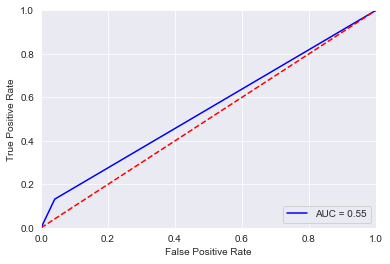

In [54]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_true=test_features.actual, y_score=test_features.preds)
roc_auc = metrics.auc(fpr, tpr)

# Draw your ROC curve
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As you can see, our model does predict more true positives than false positives, but the rate is close.

## *About the Team*

Information on the Team...